In [3]:
import cv2
import numpy as np
from SAFNet.utils.utils import calculate_psnr
import torch

# Read images
gt_path = '/root/code/hdr/SAFNet/wandb/latest-run/files/media/images/epoch_180_ground_truth_13412_a13f2ceb531a68a3d565.png'
pred_path = '/root/code/hdr/SAFNet/wandb/latest-run/files/media/images/epoch_180_predicted_13412_43c67f9f91a186ea43f5.png'

# Load images and convert to tensors
gt_img = cv2.imread(gt_path).astype(np.float32) / 255.0
pred_img = cv2.imread(pred_path).astype(np.float32) / 255.0

gt_tensor = torch.from_numpy(gt_img).permute(2,0,1).unsqueeze(0)
pred_tensor = torch.from_numpy(pred_img).permute(2,0,1).unsqueeze(0)

# Print statistics to compare distributions
print("Ground Truth Statistics:")
print(f"Mean: {gt_tensor.mean():.4f}")
print(f"Std: {gt_tensor.std():.4f}") 
print(f"Min: {gt_tensor.min():.4f}")
print(f"Max: {gt_tensor.max():.4f}")

print("\nPrediction Statistics:")
print(f"Mean: {pred_tensor.mean():.4f}")
print(f"Std: {pred_tensor.std():.4f}")
print(f"Min: {pred_tensor.min():.4f}") 
print(f"Max: {pred_tensor.max():.4f}")

# Calculate absolute difference
diff = torch.abs(gt_tensor - pred_tensor)
print("\nAbsolute Difference Statistics:")
print(f"Mean Diff: {diff.mean():.4f}")
print(f"Max Diff: {diff.max():.4f}")

Ground Truth Statistics:
Mean: 0.2316
Std: 0.2369
Min: 0.0000
Max: 1.0000

Prediction Statistics:
Mean: 0.0000
Std: 0.0000
Min: 0.0000
Max: 0.0000

Absolute Difference Statistics:
Mean Diff: 0.2316
Max Diff: 1.0000


In [10]:
# Test DiffusionUNet
import torch
from easydict import EasyDict

# Create a simple config
config = EasyDict()
config.model = EasyDict()
config.model.ch = 64
config.model.out_ch = 3
config.model.ch_mult = [1, 2, 4, 2]
config.model.num_res_blocks = 2
config.model.attn_resolutions = [16]
config.model.dropout = 0.1
config.model.in_channels = 18
config.model.resamp_with_conv = True

 
# Create model
model = DiffusionUNet(config)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total parameters: {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

# Create dummy input
x = torch.randn(1, 18, 256, 256)

# Forward pass
with torch.no_grad():
    output = model(x)
    
print("\nInput shape:", x.shape)
print("Output shape:", output.shape)

Total parameters: 14,431,747
Trainable parameters: 14,431,747

Input shape: torch.Size([1, 18, 256, 256])
Output shape: torch.Size([1, 3, 256, 256])


/root/miniconda3/envs/torch113/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


74
Dataset size: 74

Sample shapes:
Linear images: [(3, 256, 256), (3, 256, 256), (3, 256, 256)]
LDR images: [(3, 256, 256), (3, 256, 256), (3, 256, 256)]
Exposures: (3,)
Ground truth: (3, 256, 256)
LDR Low
0.99998474
0.09512329


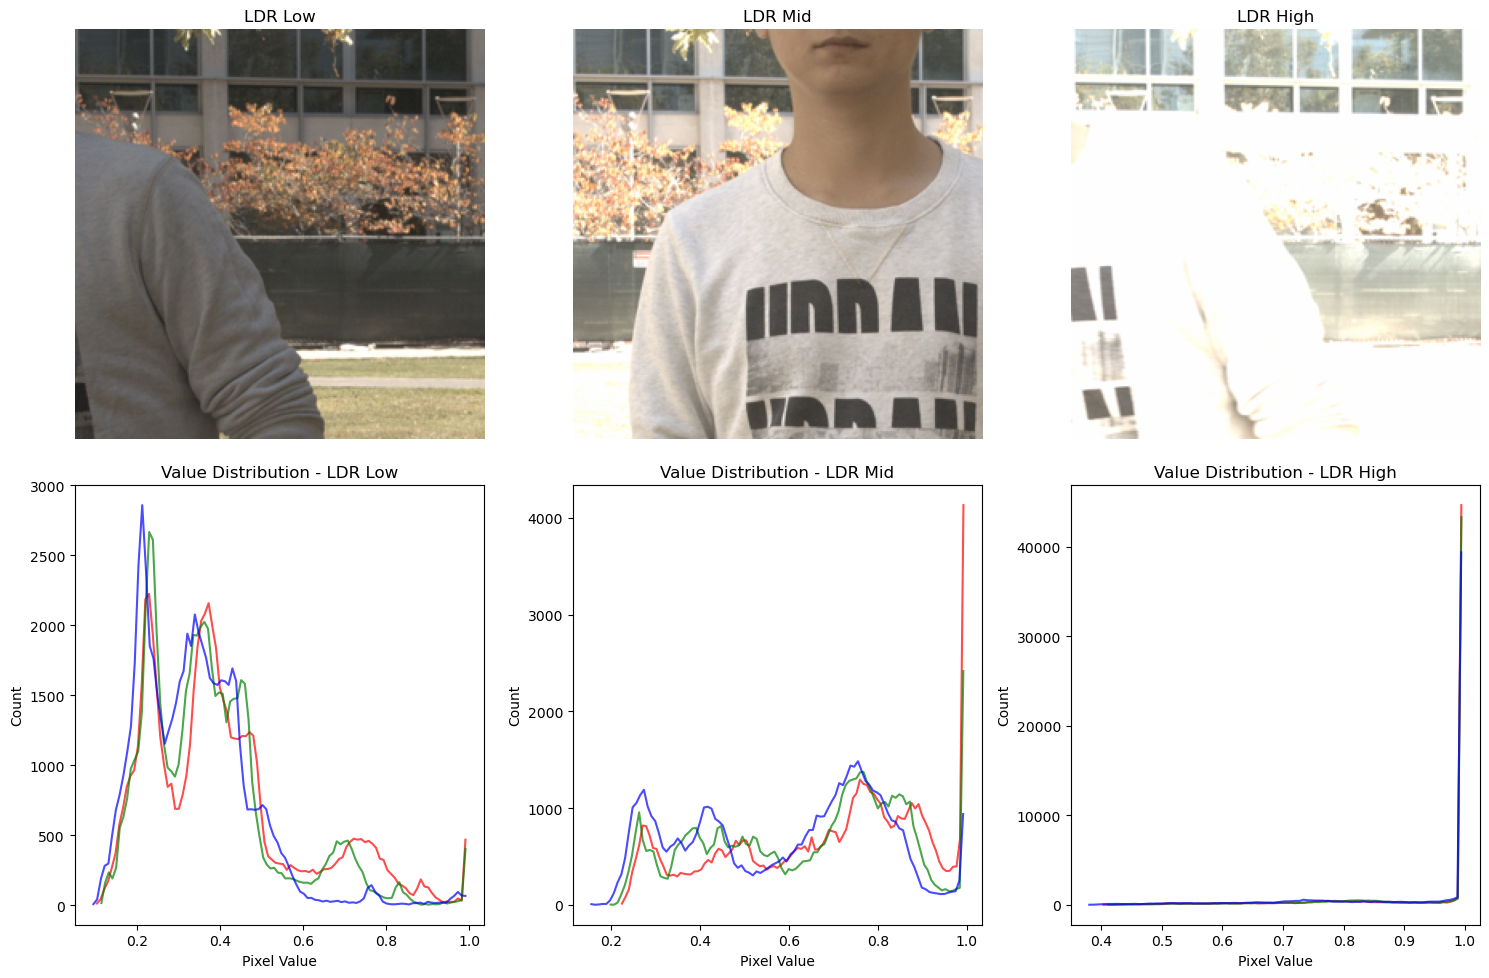

Linear Low
0.99996644
0.005652376


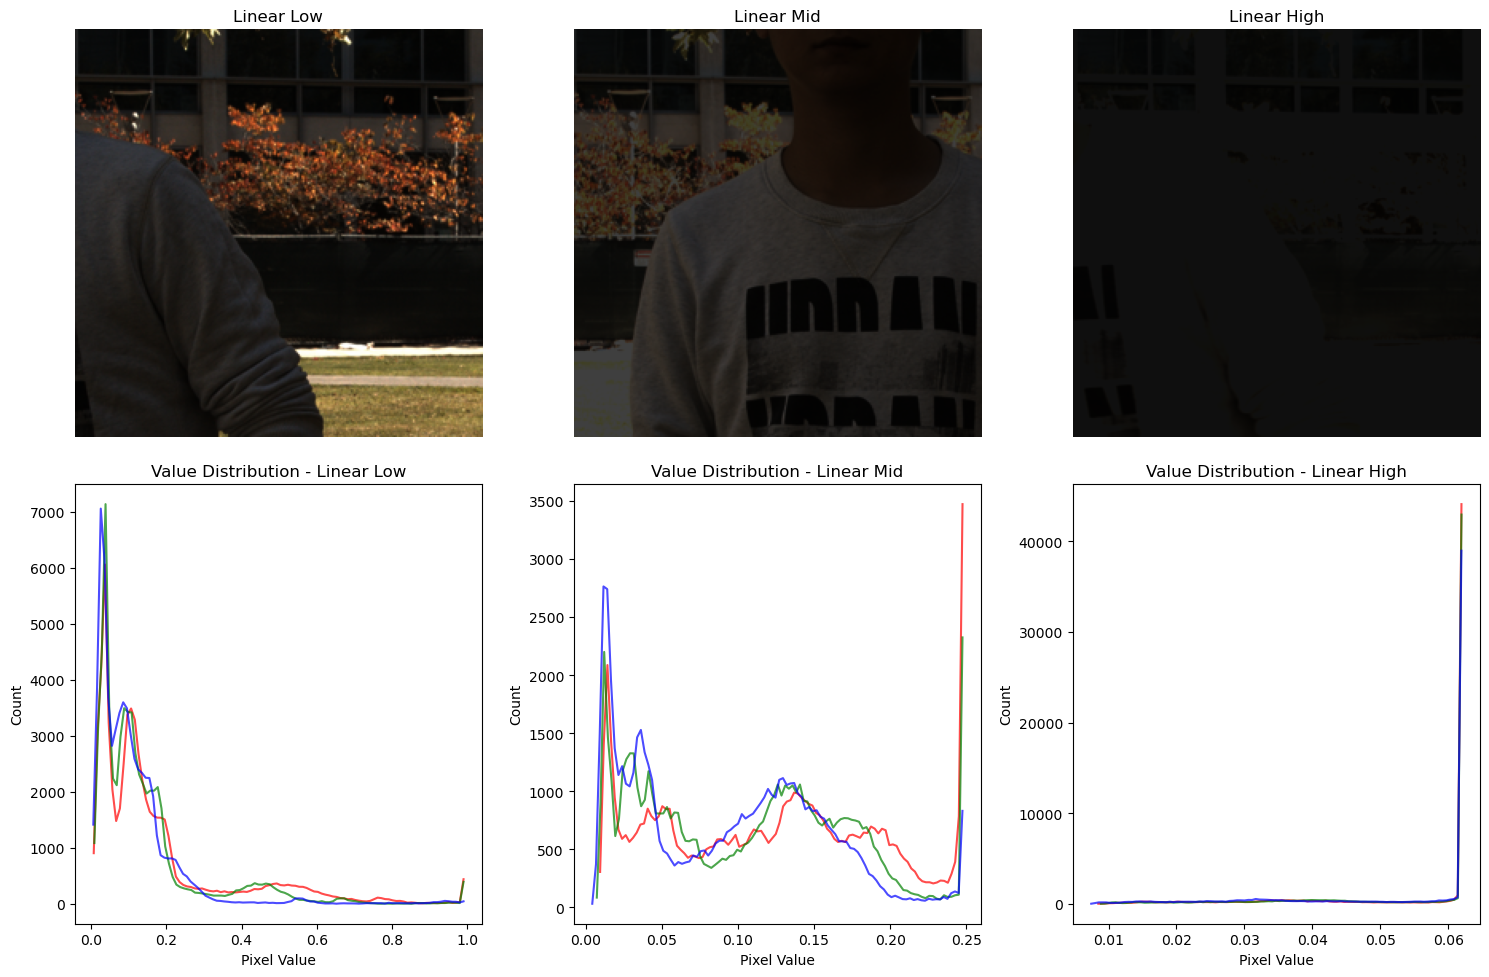

Ground Truth HDR
1.0
0.009643555


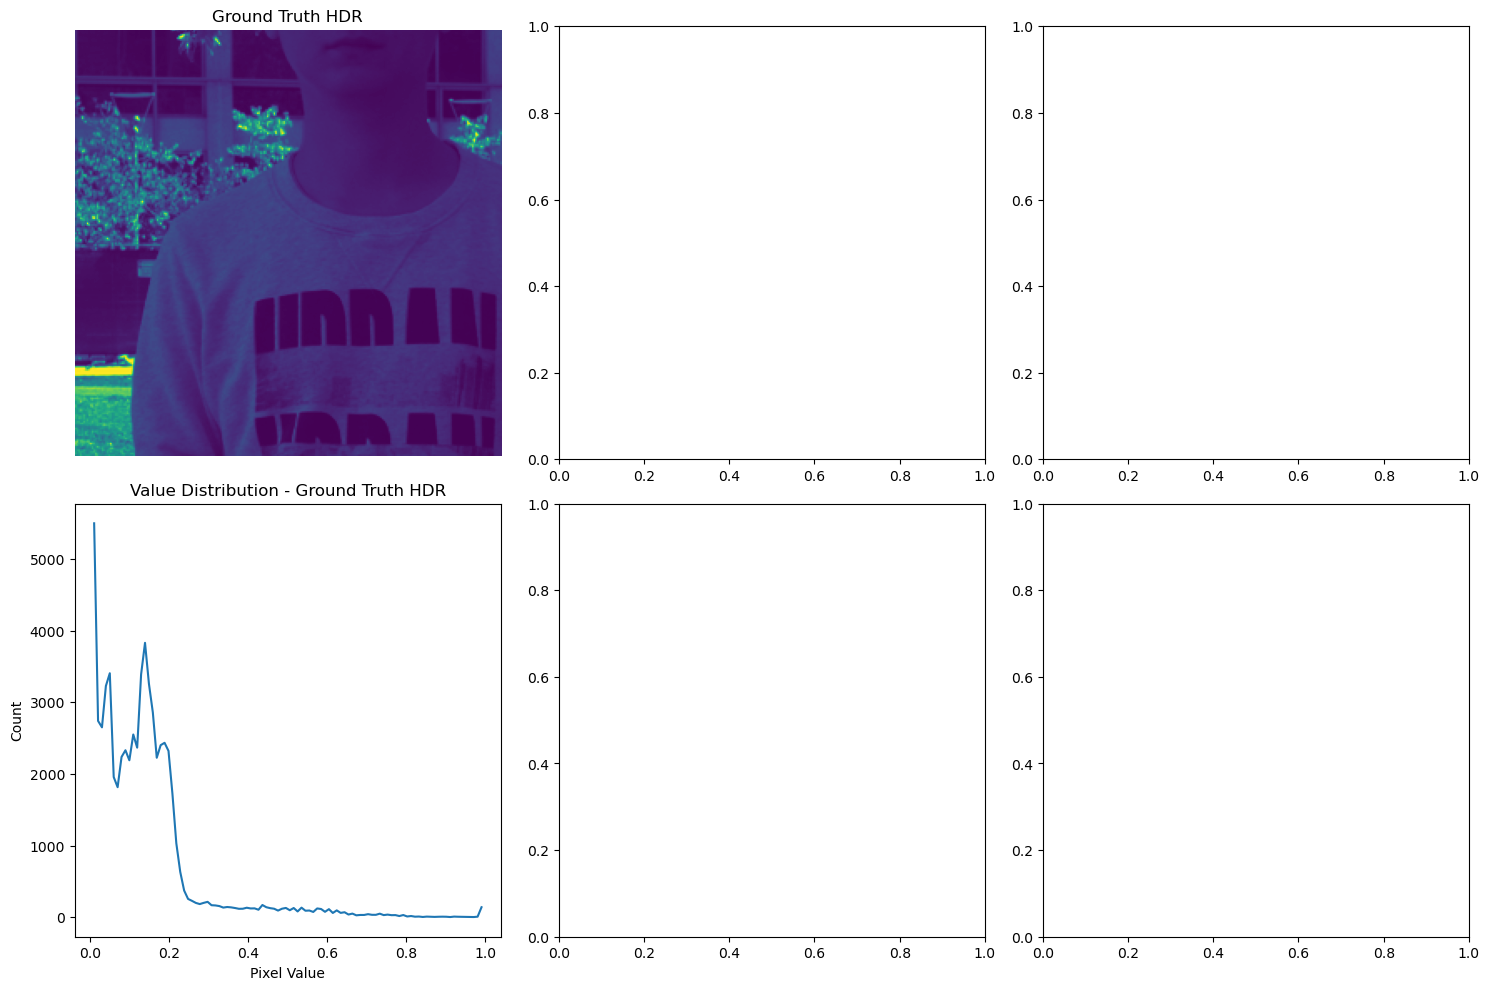

In [1]:
# Test HDRDataset
from dataset.datasets import HDRDataset
import numpy as np

# Create dataset instance
dataset = HDRDataset(root_dir="/root/code/hdr/kata17", patch_size=256)

# Get first sample
imgs_lin, imgs_ldr, expos, gt = dataset[0]

print("Dataset size:", len(dataset))
print("\nSample shapes:")
print("Linear images:", [img.shape for img in imgs_lin])
print("LDR images:", [img.shape for img in imgs_ldr]) 
print("Exposures:", expos.shape)
print("Ground truth:", gt.shape)

# Convert to tensors for visualization
import torch
import matplotlib.pyplot as plt

# Function to visualize images
def show_images(imgs, titles, rows=1, show_hist=True):
    print(titles[0])
    print(imgs[0].max())
    print(imgs[0].min())
    if show_hist:
        fig, axes = plt.subplots(rows*2, len(imgs)//rows, figsize=(15, 10*rows))
        axes = axes.reshape(2*rows, -1)
    else:
        fig, axes = plt.subplots(rows, len(imgs)//rows, figsize=(15, 5*rows))
        axes = axes.reshape(rows, -1)
    
    for i, (img, title) in enumerate(zip(imgs, titles)):
        if len(img.shape) == 3:
            img = np.transpose(img, (1, 2, 0))  # CHW -> HWC
            
        # Show image
        ax_img = axes[0][i] if show_hist else axes[i]
        ax_img.imshow(img)
        ax_img.set_title(title)
        ax_img.axis('off')
        
        # Show histogram
        if show_hist:
            ax_hist = axes[1][i]
            if len(img.shape) == 3:
                # For RGB images, plot histogram for each channel
                colors = ['r','g','b']
                for c, color in enumerate(colors):
                    hist, bins = np.histogram(img[:,:,c].flatten(), bins=100)
                    ax_hist.plot(bins[:-1], hist, color=color, alpha=0.7)
            else:
                # For grayscale images
                hist, bins = np.histogram(img.flatten(), bins=100)
                ax_hist.plot(bins[:-1], hist)
            ax_hist.set_title(f'Value Distribution - {title}')
            ax_hist.set_xlabel('Pixel Value')
            ax_hist.set_ylabel('Count')
            
    plt.tight_layout()
    plt.show()

# Show LDR images
show_images(imgs_ldr, ['LDR Low', 'LDR Mid', 'LDR High'])

# Show linear domain images 
show_images(imgs_lin, ['Linear Low', 'Linear Mid', 'Linear High'])

# Show ground truth HDR
show_images(gt, ['Ground Truth HDR'])
